## LIBRARIES

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import pandas as pd
from numpy.random import randint
from numpy.random import seed
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
import scipy
from scipy.spatial import distance_matrix
import random as rn
from numpy.random import choice as np_choice
import seaborn as sns
import os

# FUNCTIONS

In [2]:
###################################
#THIS FINDS THE CENTERS OF CLUSTERS 
###################################

def center_clusters(features,x,y,z):
    
    db = DBSCAN(eps=20,min_samples=4).fit(features)
    
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    cluster_names = list(set(labels))
    cluster_names = cluster_names[0:-1]
    label_col = labels.reshape(features.shape[0],1)
    features_labeled = np.concatenate((x,y,z,label_col), axis = 1)
    coordinates = np.zeros((n_clusters_,4))
    
    for i in range(0,len(labels)):
        
        label = round(features_labeled[i][-1])

        #if label > -1:
        for n in cluster_names:

            if n == label:

                #count of values 
                coordinates[label][3] += 1
                #x
                coordinates[label][0] += features[i][0]
                #y
                coordinates[label][1] += features[i][1] 
                #z
                coordinates[label][2] += features[i][2]
                
    for i in range(0,coordinates.shape[0]):
        
        coordinates[i][0] /= coordinates[i][3]
        coordinates[i][1] /= coordinates[i][3]
        coordinates[i][2] /= coordinates[i][3]
        
    x = coordinates[:,0]
    y = coordinates[:,1]
    z = coordinates[:,2]
    
    centers = [x,y,z]
    return x,y,z

#########################
#ANT COLONY PATH PLANNING
#########################

class AntColony(object):

    def __init__(self, distances, n_ants, n_best, n_iterations, decay, alpha=1, beta=1):
        self.distances  = distances
        self.pheromone = np.ones(self.distances.shape) / len(distances)
        self.all_inds = range(len(distances))
        self.n_ants = n_ants
        self.n_best = n_best
        self.n_iterations = n_iterations
        self.decay = decay
        self.alpha = alpha
        self.beta = beta

    def run(self):
        shortest_path = None
        all_time_shortest_path = ("placeholder", np.inf)
        for i in range(self.n_iterations):
            all_paths = self.gen_all_paths()
            self.spread_pheronome(all_paths, self.n_best, shortest_path=shortest_path)
            shortest_path = min(all_paths, key=lambda x: x[1])
            #print (shortest_path)
            if shortest_path[1] < all_time_shortest_path[1]:
                all_time_shortest_path = shortest_path
            self.pheromone = self.pheromone * self.decay
        return all_time_shortest_path

    def spread_pheronome(self, all_paths, n_best, shortest_path):
        sorted_paths = sorted(all_paths, key=lambda x: x[1])
        for path, dist in sorted_paths[:n_best]:
            for move in path:
                self.pheromone[move] += 1.0 / self.distances[move]

    def gen_path_dist(self, path):
        total_dist = 0
        for ele in path:
            total_dist += self.distances[ele]
        return total_dist

    def gen_all_paths(self):
        all_paths = []
        for i in range(self.n_ants):
            path = self.gen_path(0)
            all_paths.append((path, self.gen_path_dist(path)))
        return all_paths

    def gen_path(self, start):
        path = []
        visited = set()
        visited.add(start)
        prev = start
        for i in range(len(self.distances) - 1):
            move = self.pick_move(self.pheromone[prev], self.distances[prev], visited)
            path.append((prev, move))
            prev = move
            visited.add(move)
        path.append((prev, start)) # going back to where we started
        return path

    def pick_move(self, pheromone, dist, visited):
        pheromone = np.copy(pheromone)
        pheromone[list(visited)] = 0

        row = pheromone ** self.alpha * (( 1.0 / dist) ** self.beta)

        norm_row = row / row.sum()
        move = np_choice(self.all_inds, 1, p=norm_row)[0]
        return move


### LOADING THE DATA

In [3]:
#################################
#READING IN THE DATA FROM SCAN.PY
#################################

detected_locations = pd.read_csv('detected_locations.csv')
detected_locations.info()
detected_locations.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CLASS       300 non-null    int64  
 1   CONFIDENCE  300 non-null    float64
 2   X           300 non-null    int64  
 3   Y           300 non-null    int64  
 4   Z           300 non-null    int64  
dtypes: float64(1), int64(4)
memory usage: 11.8 KB


,CLASS,CONFIDENCE,X,Y,Z
0,2,0.5,27,234,0
1,0,0.5,13,306,1
2,1,0.5,26,222,2
3,2,0.5,6,439,10
4,3,0.5,6,205,4


### PLOTTING TO SHOW RAW DATA

C:\Users\tbsvb\anaconda3\envs\yolov3_2\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


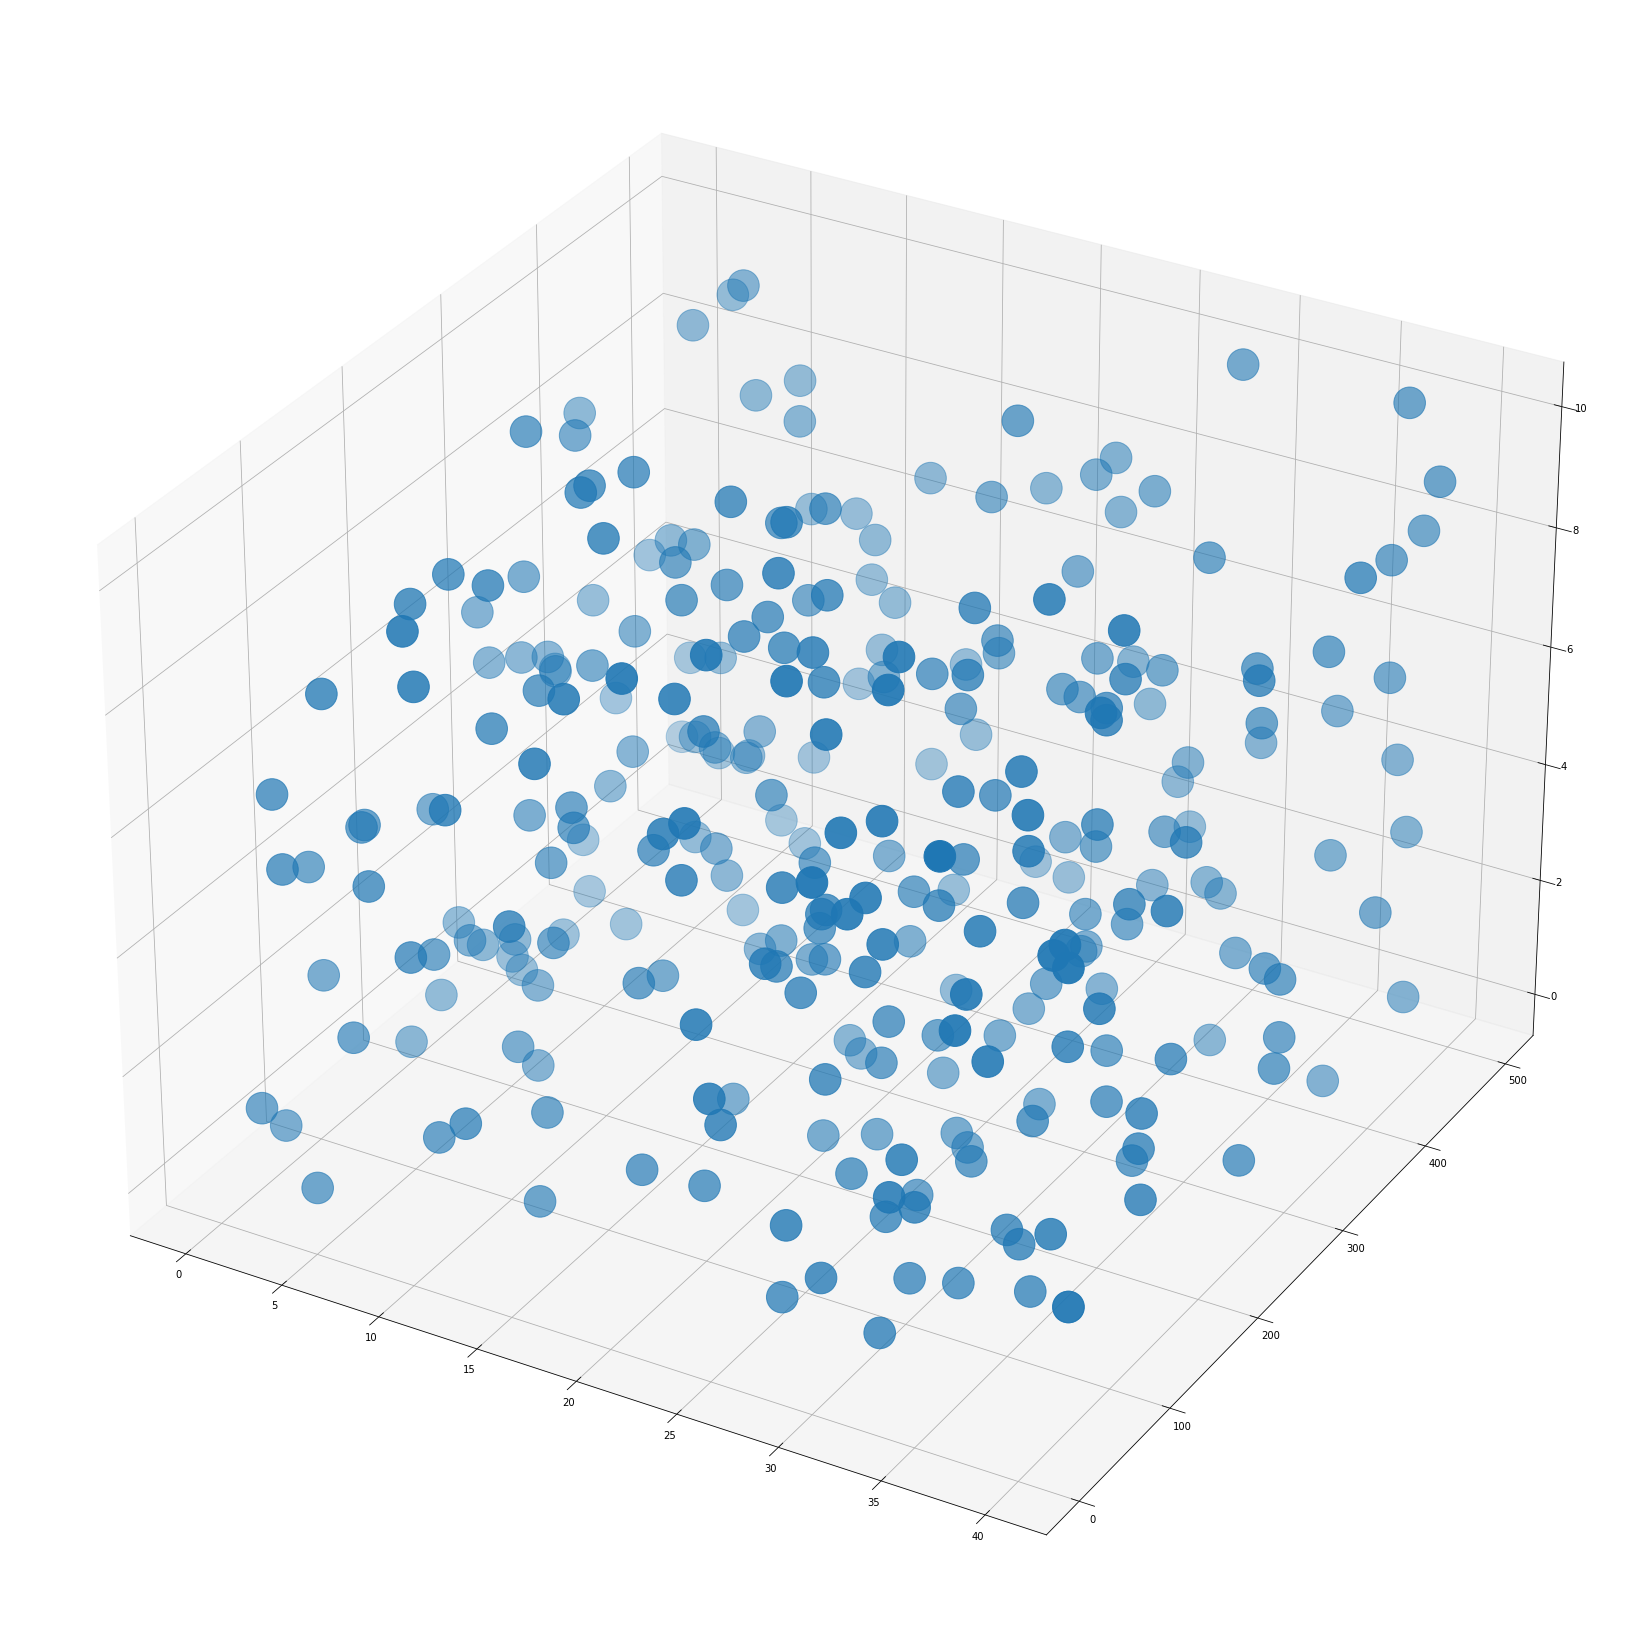

In [24]:
x = detected_locations.iloc[:,2].values
y = detected_locations.iloc[:,3].values
z = detected_locations.iloc[:,4].values

fig = plt.figure(figsize=(30,30))
plt.title('data')
ax = plt.axes(projection='3d')
ax.scatter(x,y,z,s=1000)

### FORMATTING DATA

In [5]:
########################
#REASSIGNING THE DF NAME
########################

df_loc = detected_locations

#######################
#CONVERTING TO AN ARRAY 
#######################

df_name = np.asarray(df_loc)

### FINDING THE CENTERS OF PLANTS

In [6]:
#########################################################
#THIS WILL PARSE THE DF FOR INDIVIDUAL CLASSES TO CLUSTER
#########################################################


plant_centers = pd.DataFrame(data={'CLASS':[],'X':[],'Y':[],'Z':[]})

for i in range(0,7):
    
    x = []
    y = []
    z = []
    
    ################################################
    #CHECKING EACH INSTANCE IF ITS THE CURRENT CLASS
    ################################################
    
    for n in range(0,df_loc.shape[0]):
        if df_name[n][0] == i:
            x.append(df_name[n][2])
            y.append(df_name[n][3])
            z.append(df_name[n][4])
            
    ##########################################
    #IF THERE ARE INSTANCES OF A CLASS PROCEED
    ##########################################
    
    if len(x) > 0:
        
        ##########################################
        #PREPARING INPUTS FOR HEIARCHAL CLUSTERING
        ##########################################
        
        x = np.asanyarray(x).reshape(len(x),1)
        y = np.asanyarray(y).reshape(len(y),1)
        z = np.asanyarray(z).reshape(len(z),1)
        
        features = np.concatenate((x,y,z), axis = 1)
        ################################################
        #CLUSTERING THE VALUES TO FIND CENTERS OF PLANTS
        ################################################
        
        c_x,c_y,c_z = center_clusters(features,x,y,z)

        ############################################################
        #IF THERE IS DETECTED PLANTS FOUND APPENDING THEIR LOCATIONS
        ############################################################
        
        if c_x.shape[0] > 0:
            
            #CREATING CLASSES TO COINCIDE WITH THE COORDINATES
            
            CLASSES = []
            for a in range(0,c_x.shape[0]):
                CLASSES.append(i)
            CLASSES = np.asarray(CLASSES)
            tmp_df = pd.DataFrame({'CLASS':CLASSES,'X':c_x,'Y':c_y,'Z':c_z})
            plant_centers = plant_centers.append(tmp_df,ignore_index=True)
 

### THESE ARE THE CENTERS OF THE PLANTS

In [7]:
plant_centers

,CLASS,X,Y,Z
0,0.0,9.500000,167.000000,4.000000
1,1.0,25.166667,215.500000,3.500000
2,1.0,21.875000,480.000000,5.125000
3,1.0,30.600000,77.200000,6.200000
4,1.0,32.750000,323.750000,2.000000
5,1.0,23.833333,177.833333,5.000000
6,2.0,21.333333,61.777778,4.444444
7,2.0,33.200000,114.800000,4.800000
8,3.0,17.833333,202.000000,4.500000
9,3.0,18.875000,384.750000,4.375000


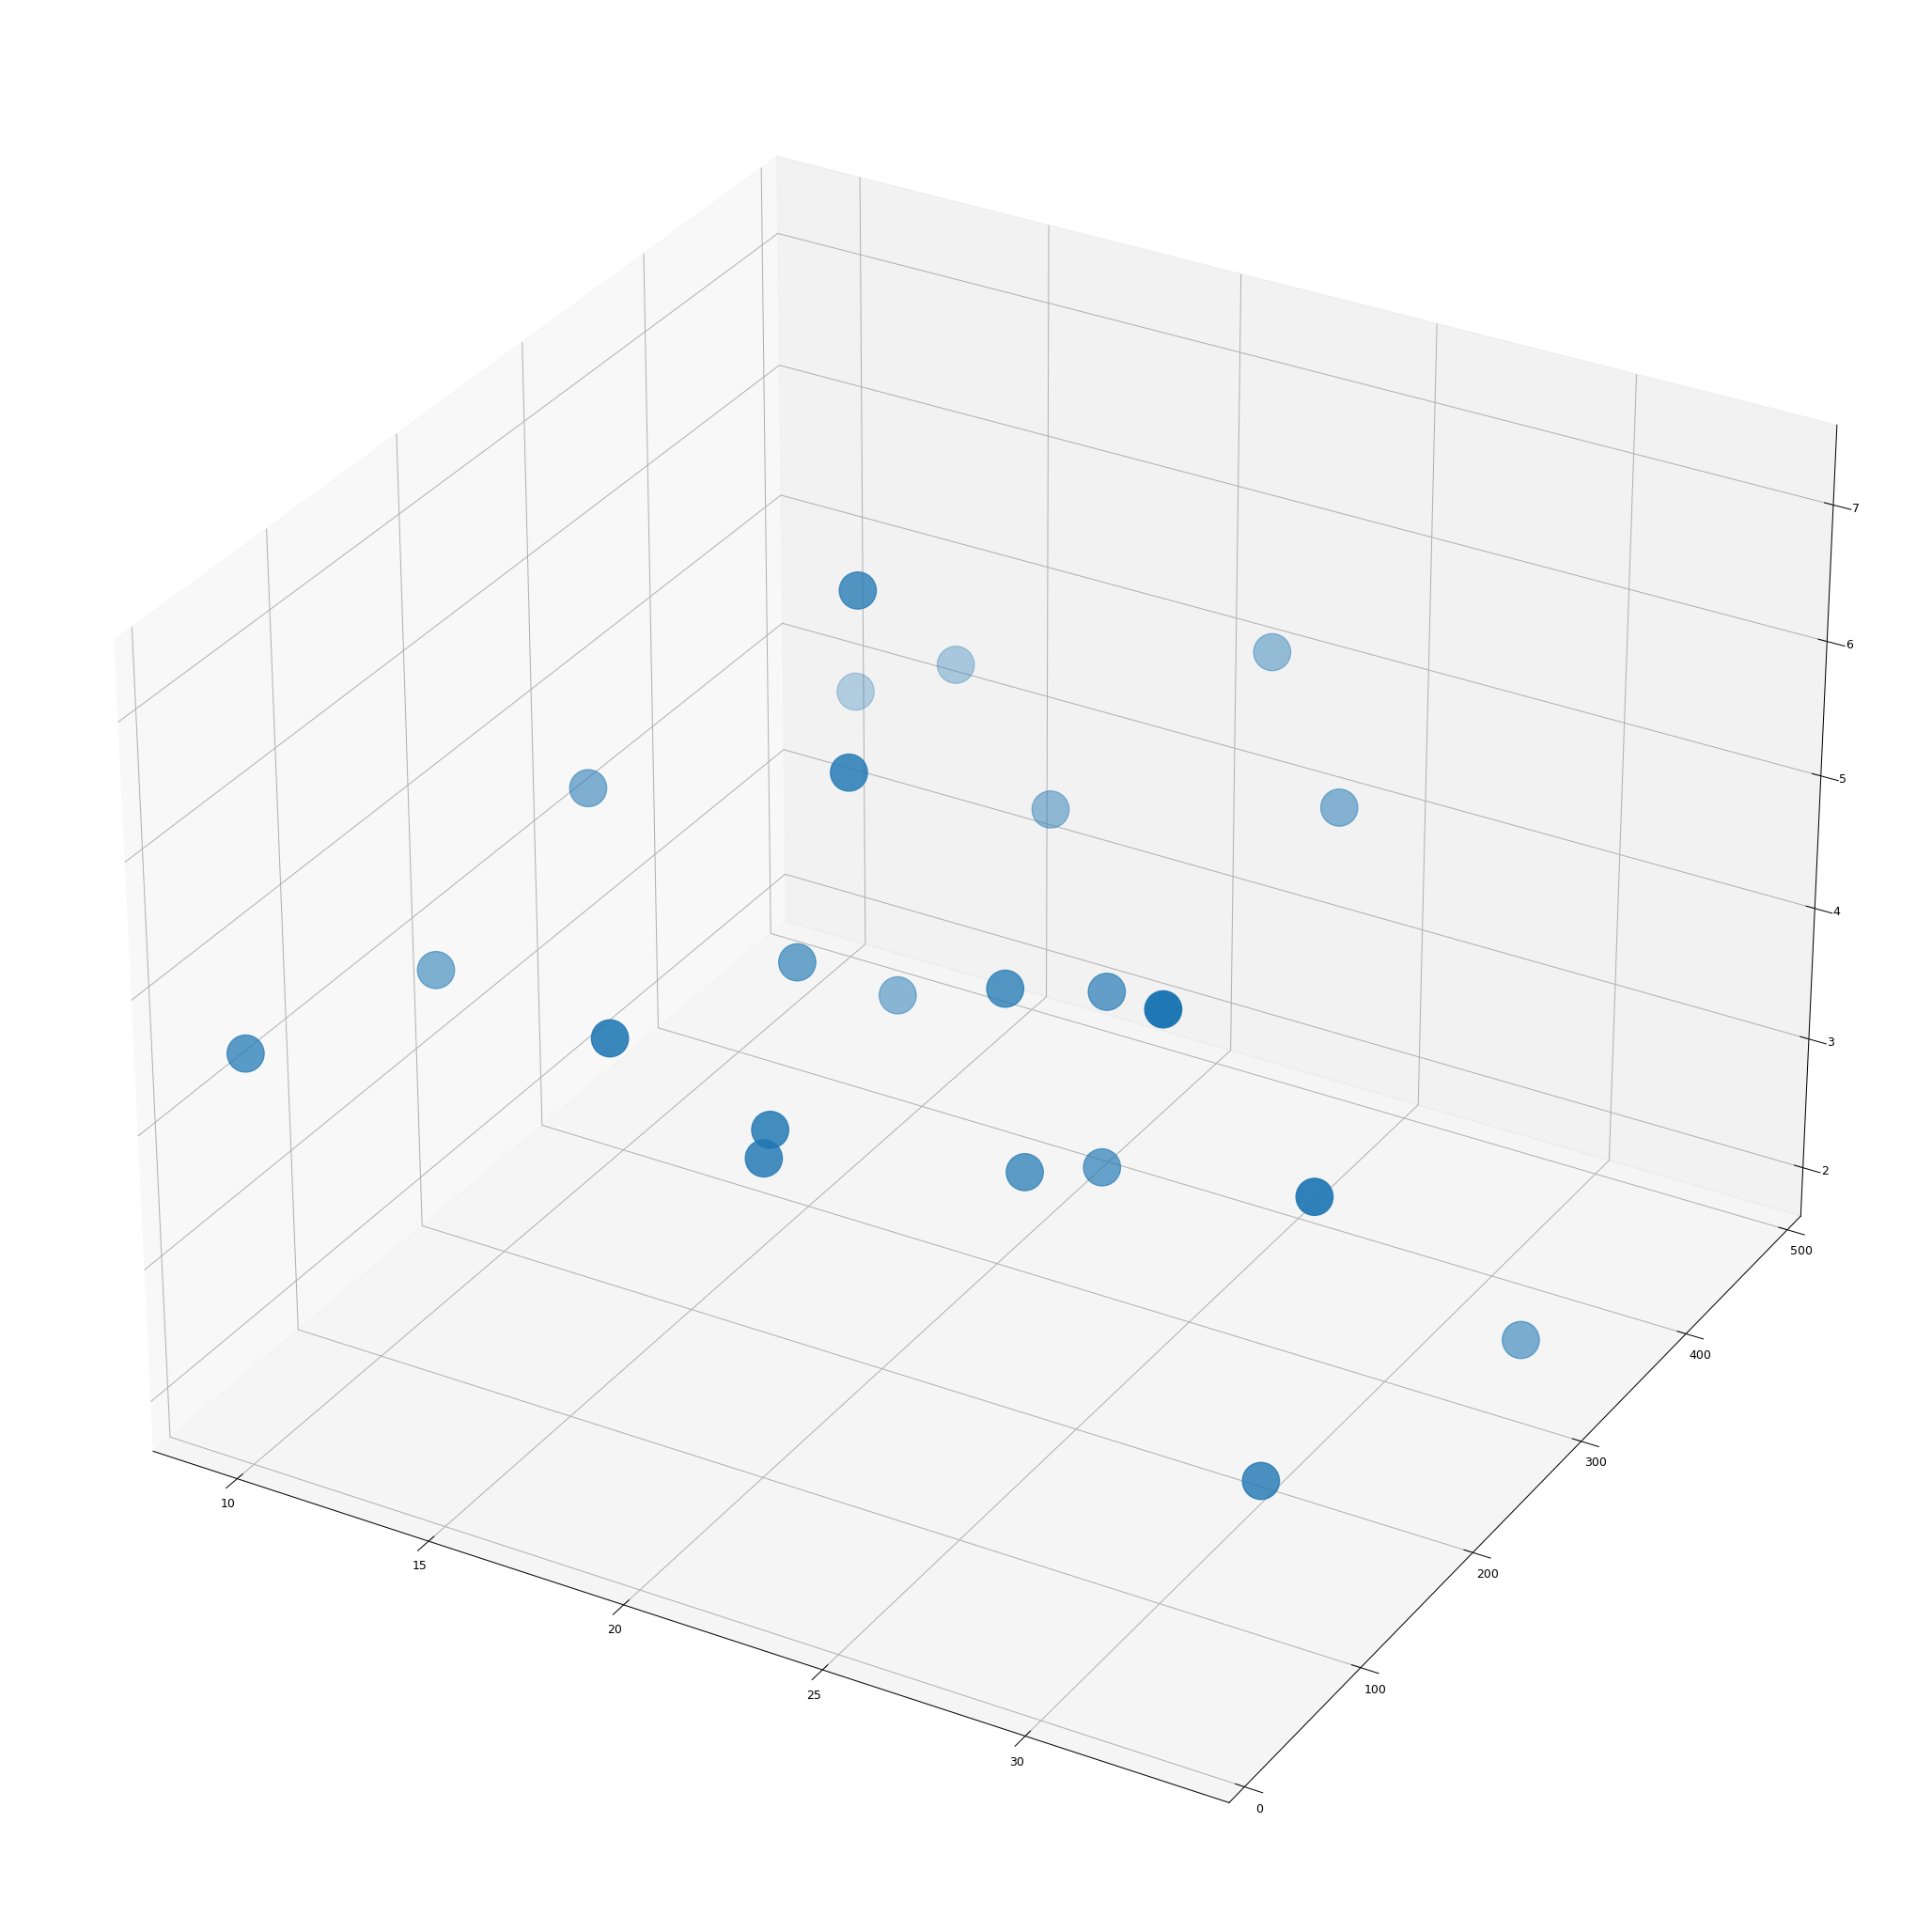

In [22]:
x = plant_centers.iloc[:,1].values
y = plant_centers.iloc[:,2].values
z = plant_centers.iloc[:,3].values

fig = plt.figure(figsize=(30,30),dpi=90)

ax = plt.axes(projection='3d')
ax.scatter(x,y,z,s=1000)

## ANT COLONY PATH PLANNING

### ROUTING OFF THE FASTEST X,Y PATH

Text(0.5, 1.0, 'X & Y POINTS    **TOPDOWN VIEW**')

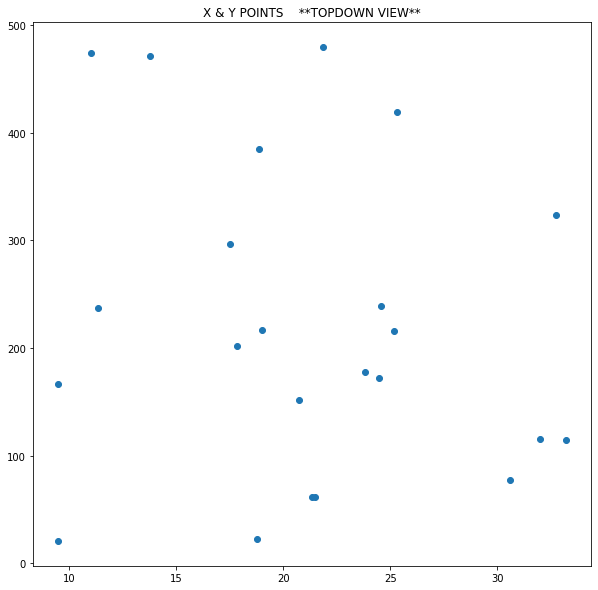

In [9]:
plt.figure(figsize=(10,10))
plt.scatter(x,y)
plt.title('X & Y POINTS    **TOPDOWN VIEW**')

In [10]:
#################################
#FORMATTING FOR ANT COLONY THE XY
#################################

x = np.array(x)
y = np.array(y)
matrix_points = []
for i in range(0, len(x)):
        matrix_points.append([x[i], y[i]])
        
matrix_points = np.array(matrix_points, dtype=float)  


In [11]:
##########################################################
#COMPUTING AN EUCLIDEAN DISTANCE MATRIX BETWEEN ALL POINTS
##########################################################

dist_points = scipy.spatial.distance_matrix(matrix_points, matrix_points)
for i in range(0,dist_points.shape[1]):
    for n in range(0,dist_points.shape[0]):
        if dist_points[i,n] == 0:
            dist_points[i,n] = np.inf

In [12]:
########################################
#RUNNING THE ANT COLONY PATHING FUNCTION 
########################################
ant_colony = AntColony(dist_points, 1, 1, 100, 0.95, alpha=1, beta=1)
shortest_path = ant_colony.run()
best_path = np.asarray(shortest_path[0:len(shortest_path)-1])

In [13]:
#################################################
#EXTRACTING WHICH XY POINTS TO TRAVEL TO IN ORDER
#################################################

path_x = []
path_y = []
for i in range(0,matrix_points.shape[0]):
       first_index = best_path[0,i][0]
       path_x.append(matrix_points[first_index,0])
       path_y.append(matrix_points[first_index,1]) 
        
path_x = np.asarray(path_x)
path_y = np.asarray(path_y) 


In [14]:
###########################################
#REASSIGNING THE CLASSES TO THE COORDINATES
###########################################

center_classes = plant_centers.iloc[:,0].values
center_classes = np.asarray(center_classes)
ordered_classes = []

for i in range(0,len(x)):
    print('x: ',path_x[i],'y: ', path_y[i])
    for n in range(0,len(x)):
        if path_x[i] == x[n]:
            if path_y[i]==y[n]:
                ordered_classes.append(round(center_classes[n]))
                


x:  9.5 y:  167.0
x:  23.833333333333332 y:  177.83333333333334
x:  24.5 y:  172.0
x:  17.833333333333332 y:  202.0
x:  19.0 y:  216.8
x:  25.166666666666668 y:  215.5
x:  24.571428571428573 y:  239.28571428571428
x:  11.333333333333334 y:  236.83333333333334
x:  17.5 y:  297.0
x:  32.75 y:  323.75
x:  18.875 y:  384.75
x:  25.333333333333332 y:  419.1666666666667
x:  13.777777777777779 y:  471.8888888888889
x:  21.875 y:  480.0
x:  11.0 y:  474.0
x:  20.75 y:  151.75
x:  32.0 y:  115.8
x:  33.2 y:  114.8
x:  30.6 y:  77.2
x:  21.5 y:  61.833333333333336
x:  21.333333333333332 y:  61.77777777777778
x:  9.5 y:  20.5
x:  18.8 y:  22.4


[0, 1, 4, 3, 5, 1, 3, 6, 5, 1, 3, 6, 3, 1, 5, 5, 4, 2, 1, 4, 2, 5, 4]
[0. 1. 1. 1. 1. 1. 2. 2. 3. 3. 3. 3. 4. 4. 4. 4. 5. 5. 5. 5. 5. 6. 6.]


Text(0.5, 1.0, 'Optimal Path')

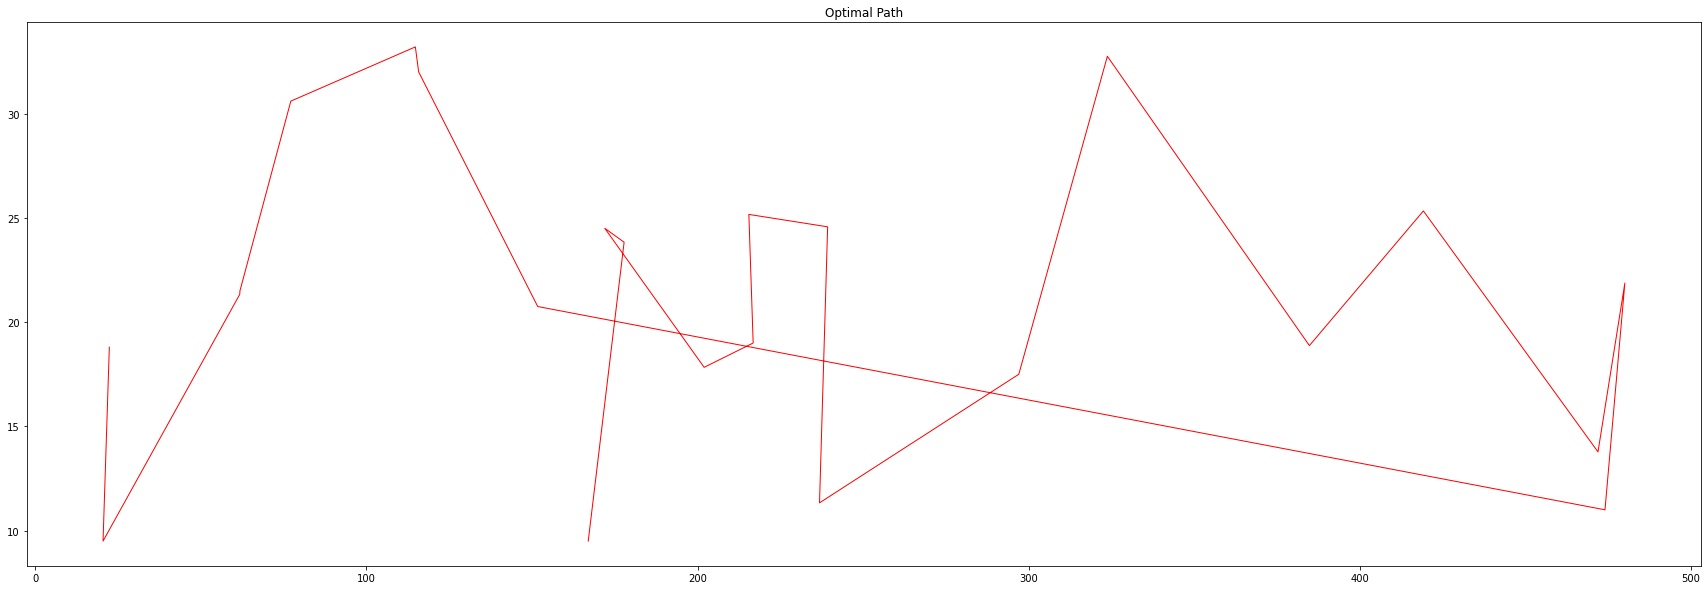

In [28]:
print(ordered_classes)
print(center_classes)
plt.figure(figsize=(30,10))
plt.plot(path_y,path_x,lw = 1,color = 'red')
plt.title('Optimal Path')


In [16]:
original_data = {'X':x,
                'Y':y,
                'Class':center_classes}
original_df = pd.DataFrame(original_data)
original_df

,X,Y,Class
0,9.500000,167.000000,0.0
1,25.166667,215.500000,1.0
2,21.875000,480.000000,1.0
3,30.600000,77.200000,1.0
4,32.750000,323.750000,1.0
5,23.833333,177.833333,1.0
6,21.333333,61.777778,2.0
7,33.200000,114.800000,2.0
8,17.833333,202.000000,3.0
9,18.875000,384.750000,3.0


In [17]:
###########################################################
#WRITING THE ORDERED LOCATIONS OF PLANTS TO TRAVEL TO A CSV
###########################################################

if os.path.exists('Ordered_Plant_Locations.csv'):
    os.remove('Ordered_Plant_Locations.csv')

pathed_data = {'X':path_x,
                'Y':path_y,
                'Class':ordered_classes}
pathed_df = pd.DataFrame(pathed_data)
pathed_df.to_csv('Ordered_Plant_Locations.csv')